In [1]:
# --- Блок 0: Проверка окружения и библиотек ---

# Версия Python
import sys, os, warnings
print("Python:", sys.version.split()[0])

Python: 3.12.3


## Импорт необходимых библиотек

In [2]:
# Подавление предупреждений (чтобы не засоряли вывод)
for warn in [UserWarning, FutureWarning]:
    warnings.filterwarnings("ignore", category=warn)

# Импорт библиотек
import numpy as np
import pandas as pd

# Версию для GPU нужно подобрать под CUDA https://pytorch.org/get-started/locally
import torch
import torch.nn as nn
from dataclasses import dataclass

In [3]:
# Таблица с версиями библиотек
packages = ["Torch", "NumPy", "Pandas"]
package_objects = [torch, np, pd]
versions = [obj.__version__ if obj is not None else "not-installed" for obj in package_objects]

df_pkgs = pd.DataFrame({"Библиотека": packages, "Версия": versions})
df_pkgs.index.name = "№"
df_pkgs.index = df_pkgs.index + 1
display(df_pkgs)

# Сохраним список библиотек и их версий в requirements.txt
path_to_reqs = "."
reqs_name = "requirements.txt"

def get_packages_and_versions():
    for package, version in zip(packages, versions):
        v = version if version != "not-installed" else ""
        sep = "==" if v else ""
        yield f"{package.lower()}{sep}{v}\n"

with open(os.path.join(path_to_reqs, reqs_name), "w", encoding="utf-8") as f:
    f.writelines(get_packages_and_versions())

# Проверим доступность CUDA для ускорения вычислений
cuda_info = {
    "torch.cuda.is_available": torch.cuda.is_available(),
    "torch.version.cuda": torch.version.cuda,
}
print("CUDA:", cuda_info)

,Библиотека,Версия
№,,
1,Torch,2.6.0+cu118
2,NumPy,2.3.3
3,Pandas,2.3.2


CUDA: {'torch.cuda.is_available': True, 'torch.version.cuda': '11.8'}


---
# Регрессия
---

## L1Loss - L1-норма или MAE, Mean Absolute Error (средняя абсолютная ошибка)

---



**Определение:**  
Измерение средней абсолютной разницы между предсказанными и истинными значениями нейросетевой модели:  

$$
\mathrm{MAE}(y, \hat{y}) = \frac{1}{n}\sum_{i=1}^{n} \lvert y_i - \hat{y}_i \rvert
$$

**Когда использовать:**  
- В задачах регрессии, когда важно иметь устойчивость к выбросам.  
- MAE растёт линейно с ошибкой, поэтому большие отклонения не «доминируют» так сильно, как в MSE.  

**Свойства:**  
- Градиенты по модулю постоянны (кроме точки совпадения).  
- Может сходиться медленнее на задачах без выбросов.  

**В PyTorch:**  
```python
nn.L1Loss(reduction="mean" | "sum" | "none")`  


In [6]:
# Фиксируем генераторы случайных чисел (для воспроизводимости экспериментов)
torch.manual_seed(42)
np.random.seed(42)

# 1. Функция потерь (MAE)
loss = nn.L1Loss(reduction="mean")

# 2. "Предсказания" модели
input = torch.randn(2, 3, requires_grad=True)

# 3. "Истинные" значения (метки)
target = torch.randn(2, 3)

print("Предсказания (input):\n", input)
print("Истинные значения (target):\n", target)

# 4. Вычисление функции потерь
output = loss(input, target)
print("\nСредняя абсолютная разница (L1):", output.item())

# 5. Обратное распространение ошибки
output.backward()
print("\nГрадиенты по входным данным:\n", input.grad)


Предсказания (input):
 tensor([[ 0.3367,  0.1288,  0.2345],
        [ 0.2303, -1.1229, -0.1863]], requires_grad=True)
Истинные значения (target):
 tensor([[ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094]])

Средняя абсолютная разница (L1): 0.9259961247444153

Градиенты по входным данным:
 tensor([[-0.1667,  0.1667, -0.1667],
        [-0.1667, -0.1667, -0.1667]])


## На примере L1 подробно рассмотрим как работает backward() (backpropagation) и зачем нужны градиенты

Backpropagation (обратное распространение ошибки) — это алгоритм, при котором ошибка на выходе модели прокатывается назад по вычислительному графу с помощью правила цепочки, чтобы вычислить градиенты для всех параметров.

Когда мы вычисляем loss в PyTorch, он строит **граф вычислений** от `input` к `loss`.  
Если у `input` стоит `requires_grad=True`, PyTorch будет отслеживать все операции, чтобы потом найти производные.

### 1. Производные и градиенты
- Производная (derivative) показывает, **как сильно меняется функция при малом изменении аргумента**.  
  Например, для $f(x) = x^2$ имеем $f'(x) = 2x$. В точке $x=2$: $f'(2)=4$, значит, если $x$ увеличится на $0.01$, $f(x)$ вырастет примерно на $0.04$.
- В многомерном случае мы считаем частные производные по каждому элементу входа:  

$$
\nabla_x L = 
\begin{bmatrix}
\frac{\partial L}{\partial x_{11}} &
\frac{\partial L}{\partial x_{12}} &
\dots
\end{bmatrix}
$$

Этот вектор/матрица называется **градиент**.

### 2. Как PyTorch находит градиенты
- Мы вычисляем $loss = L(input, target)$.
- Вызываем `loss.backward()`.
- PyTorch применяет **правило цепочки (chain rule)** и идёт по графу операций «назад», считая производные на каждом шаге.
- В результате в `input.grad` (и в `.grad` всех других параметров модели) появляются значения $\frac{\partial L}{\partial input}$.

> Примечание: в учебных примерах мы ставим `requires_grad=True` у `input`, чтобы увидеть **градиенты по предсказаниям**.  
> В реальном обучении этот флаг обычно у **параметров модели** (весов), и именно они обновляются оптимизатором.

### 3. Что значит `input.grad`
- Каждый элемент в `input.grad` показывает:
> «Если изменить соответствующий элемент `input` на чуть-чуть, то как изменится loss».
- Знак градиента:
  - Отрицательный → увеличение этого элемента **повысит loss** (чтобы уменьшить loss, элемент нужно уменьшать).
  - Положительный → увеличение этого элемента **снизит loss** (чтобы уменьшить loss, элемент нужно увеличивать).

### 4. Градиентный спуск
Используя градиенты, обновляем параметры так:

$$
x_{\text{новый}} = x - \eta \cdot \nabla_x L
$$

где $\eta$ — шаг обучения (learning rate).  
Градиенты нужны не ради самих чисел, а чтобы **подсказать направление движения к минимуму функции потерь**.

---

## 5. Демонстрация на L1Loss (seed=42)

**Вывод из кода (формат 2×3):**

Предсказания (input):
tensor([[ 0.3367, 0.1288, 0.2345],
[ 0.2303, -1.1229, -0.1863]], requires_grad=True)

Истинные значения (target):
tensor([[ 2.2082, -0.6380, 0.4617],
[ 0.2674, 0.5349, 0.8094]])

Средняя абсолютная разница (L1): 0.9259961247444153

Градиенты по входным данным:
tensor([[-0.1667, 0.1667, -0.1667],
[-0.1667, -0.1667, -0.1667]])



### 5.1. Формула L1Loss
Средняя абсолютная ошибка:
$$
L = \frac{1}{n} \sum_{i=1}^n \big| \hat{y}_i - y_i \big|
$$
Здесь $n = 2 \times 3 = 6$ элементов, значит коэффициент усреднения $1/n \approx 0.1667$.

### 5.2. Проверка значения лосса на числах
Считаем поэлементно $|\hat{y}-y|$ и усредняем:
- $(0,0): |0.3367 - 2.2082| = 1.8715$
- $(0,1): |0.1288 - (-0.6380)| = 0.7668$
- $(0,2): |0.2345 - 0.4617| = 0.2272$
- $(1,0): |0.2303 - 0.2674| = 0.0371$
- $(1,1): |-1.1229 - 0.5349| = 1.6578$
- $(1,2): |-0.1863 - 0.8094| = 0.9957$

Сумма $\approx 5.5561$, среднее $5.5561/6 \approx 0.9260$ — совпадает с выводом `0.925996...`.

### 5.3. Откуда берутся такие градиенты при L1
Чтобы найти градиенты, берём производную от функции потерь по каждому предсказанию $\hat{y}_i$:

1. Берём отдельный член суммы:
   $$
   f(\hat{y}_i) = |\hat{y}_i - y_i|
   $$
2. Дифференцируем по $\hat{y}_i$. Производная от модуля:
   $$
   \frac{d}{dz}|z| =
   \begin{cases}
   +1, & z > 0 \\
   -1, & z < 0 \\
   0, & z = 0
   \end{cases}
   = \mathrm{sign}(z)
   $$
3. Подставляем $z = \hat{y}_i - y_i$:
   $$
   \frac{\partial}{\partial \hat{y}_i} |\hat{y}_i - y_i| = \mathrm{sign}(\hat{y}_i - y_i)
   $$
4. С учётом усреднения на $n$ элементов:
   $$
   \frac{\partial L}{\partial \hat{y}_i} = \frac{1}{n}\,\mathrm{sign}(\hat{y}_i - y_i)
   $$

Отсюда и появляются значения $\pm 0.1667$ (или 0, если предсказание совпало с меткой).

Примеры:
- $(0,1):\; 0.1288 - (-0.6380) = +0.7668 \Rightarrow \mathrm{sign}=+1 \Rightarrow +0.1667$  
- $(0,0):\; 0.3367 - 2.2082 = -1.8715 \Rightarrow \mathrm{sign}=-1 \Rightarrow -0.1667$  
- $(1,1):\; -1.1229 - 0.5349 = -1.6578 \Rightarrow \mathrm{sign}=-1 \Rightarrow -0.1667$

### 5.4. Как это «читает» градиентный спуск
Что значат эти градиенты для обучения:

- **Если градиент отрицательный** ($-0.1667$):  
  это значит, что $\hat{y} < y$.  
  Если мы увеличим предсказание, loss уменьшится.  
  В градиентном спуске шаг идёт против градиента, поэтому параметр будет **увеличен**.  

- **Если градиент положительный** ($+0.1667$):  
  это значит, что $\hat{y} > y$.  
  Если мы уменьшим предсказание, loss уменьшится.  
  В градиентном спуске параметр будет **уменьшен**.  

- **Если градиент равен нулю**:  
  значит предсказание совпало с меткой → в этой точке ошибка уже минимальна, ничего менять не нужно.  

Таким образом, градиенты — это «стрелочки-команды», которые указывают, в какую сторону двигать предсказания (а в реальном обучении — параметры модели), чтобы **минимизировать функцию потерь**.



---
## MSELoss (Mean Squared Error, среднеквадратичная ошибка)

---


**Определение:**  
Измерение среднеквадратичной ошибки между предсказанными и истинными значениями нейросетевой модели.:  

$$
\mathrm{MSE}(y, \hat{y}) = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

**Когда использовать:**  
- Классическая функция потерь для задач регрессии.  
- Хорошо работает, когда важна сильная penalизация больших ошибок.  

**Свойства:**  
- Большие ошибки влияют квадратично (в отличие от MAE, где линейно).  
- Может быть чувствительна к выбросам.  
- Градиенты пропорциональны величине ошибки: чем больше ошибка, тем сильнее обновление параметров.  

**В PyTorch:**  
```python
nn.MSELoss(reduction="mean" | "sum" | "none")

In [7]:
# Фиксируем seed, чтобы генерация случайных чисел была воспроизводимой
torch.manual_seed(42)

# 1. Функция потерь: среднеквадратичная ошибка
# reduction="mean" → усредняем по всем элементам
# ("sum" → сумма, "none" → без агрегации, возвращает матрицу ошибок)
loss = nn.MSELoss(reduction="mean")

# 2. "Предсказания" модели (любая матрица, которую считаем выходом)
input = torch.randn(2, 3, requires_grad=True)

# 3. "Истинные" значения (метки)
target = torch.randn(2, 3)

print("Предсказания (input):\n", input)
print("Истинные значения (target):\n", target)

# 4. Вычисляем loss
# формула: mean((input - target)^2)
output = loss(input, target)
print("\nСреднеквадратичная ошибка (MSE):", output.item())

# 5. backward() → обратное распространение ошибки
# PyTorch вычислит ∂L/∂input для каждого элемента
output.backward()
print("\nГрадиенты по входным данным:\n", input.grad)


Предсказания (input):
 tensor([[ 0.3367,  0.1288,  0.2345],
        [ 0.2303, -1.1229, -0.1863]], requires_grad=True)
Истинные значения (target):
 tensor([[ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094]])

Среднеквадратичная ошибка (MSE): 1.3138492107391357

Градиенты по входным данным:
 tensor([[-0.6238,  0.2556, -0.0757],
        [-0.0123, -0.5526, -0.3319]])


---
## PoissonNLLLoss (Negative Log Likelihood для распределения Пуассона)

---

**Определение:**  
PoissonNLLLoss вычисляет отрицательное логарифмическое правдоподобие (NLL), если считать, что каждое целевое значение $y_i$ сгенерировано из распределения Пуассона.  

Формула зависит от параметра `log_input`:

- Если `log_input=True` (обычно так используют, так как модель предсказывает логарифм интенсивности $\lambda$):
$$
L = \frac{1}{n} \sum_{i=1}^n \big( \exp(\hat{x}_i) - y_i \cdot \hat{x}_i \big)
$$
где $\hat{x}_i$ — логарифм интенсивности (лог-ламбда).  

- Если `log_input=False` (тогда вход — сама интенсивность $\hat{y}$):
$$
L = \frac{1}{n} \sum_{i=1}^n \big( \hat{y}_i - y_i \cdot \log(\hat{y}_i + \epsilon) \big)
$$

- Если `full=True`, добавляется слагаемое $+\log(y_i!)$, делающее loss эквивалентным полному логарифму правдоподобия распределения Пуассона.  
По умолчанию оно не нужно, так как не влияет на градиенты.  

---

### Разбор формулы
1. **Слагаемое $\exp(\hat{x}_i)$ или $\hat{y}_i$:**
   - Ожидаемое количество событий (среднее распределения Пуассона).  
   - Это «стоимость» предсказания: чем больше интенсивность, тем выше ожидаемое значение loss.  

2. **Слагаемое $-y_i \cdot \hat{x}_i$ или $-y_i \cdot \log(\hat{y}_i)$:**
   - Показывает, насколько хорошо предсказание объясняет наблюдаемое $y_i$.  
   - Чем ближе предсказание к наблюдаемым данным, тем меньше loss.  

---

### Когда использовать
- Для регрессии **счётных данных** (например, число заказов, количество кликов, число событий во времени).  
- Особенно полезен, когда данные распределены не как гауссиана, а как **счётные неотрицательные величины**.  

---

### Свойства
- Предполагается свойство распределения Пуассона: **среднее = дисперсия**.  
- Если дисперсия данных сильно отличается, может работать хуже.  
- Удобен для задач, где предсказания должны быть $\geq 0$ (счётчики).  

---

### В PyTorch
```python
nn.PoissonNLLLoss(
    log_input=True,   # True → вход = log λ ; False → вход = λ
    full=False,       # True → добавляем +log(y!) в формулу
    eps=1e-8,         # защита от log(0), если log_input=False
    reduction="mean"  # "mean" | "sum" | "none"
)


In [8]:
torch.manual_seed(42)

# 1. Функция потерь: отрицательное лог-правдоподобие Пуассона
loss = nn.PoissonNLLLoss(log_input=True, full=False, eps=1e-8, reduction="mean")

# 2. "Предсказания" модели (логарифмы интенсивности λ)
input = torch.randn(2, 3, requires_grad=True)

# 3. "Истинные" счётные данные (количество событий, ≥ 0)
# берём abs(), чтобы гарантировать неотрицательность
target = torch.abs(torch.randn(2, 3))

print("Предсказания:\n", input)
print("Истинные значения (target):\n", target)

# 4. Loss считается по формуле:
# L = mean(exp(input) - target * input)   (при log_input=True)
output = loss(input, target)
print("\nЗначение функции потерь (PoissonNLLLoss):", output.item())

# 5. Вычисляем градиенты по input
output.backward()
print("\nГрадиенты по входным данным:\n", input.grad)

Предсказания:
 tensor([[ 0.3367,  0.1288,  0.2345],
        [ 0.2303, -1.1229, -0.1863]], requires_grad=True)
Истинные значения (target):
 tensor([[2.2082, 0.6380, 0.4617],
        [0.2674, 0.5349, 0.8094]])

Значение функции потерь (PoissonNLLLoss): 0.9953872561454773

Градиенты по входным данным:
 tensor([[-0.1346,  0.0832,  0.1338],
        [ 0.1653, -0.0349,  0.0034]])


---
## GaussianNLLLoss (Negative Log Likelihood для нормального распределения)
---

**Определение:**  
GaussianNLLLoss вычисляет отрицательное логарифмическое правдоподобие (NLL), если считать, что каждое целевое значение $y_i$ сгенерировано из нормального распределения с параметрами:
- среднее $\hat{y}_i$ (предсказание модели),
- дисперсия $\sigma_i^2$ (неопределённость, также предсказывается моделью).  

$$
L = \frac{1}{n}\sum_{i=1}^n \left( 
\frac{(y_i - \hat{y}_i)^2}{2\sigma_i^2} + \frac{1}{2}\log\sigma_i^2
\right)
$$

---

### Разбор формулы
1. **Слагаемое ошибки:**

$$
\frac{(y_i - \hat{y}_i)^2}{2\sigma_i^2}
$$  

- Чем больше разница $(y_i - \hat{y}_i)$, тем больше штраф.  
- Но если дисперсия $\sigma_i^2$ велика, ошибка «размывается» → модель признаёт высокую неопределённость.

2. **Слагаемое регуляризации:**

$$
\frac{1}{2}\log\sigma_i^2
$$  

- Если дисперсия слишком большая, это слагаемое растёт и наказывает модель.  
- Если дисперсия слишком маленькая, первое слагаемое становится огромным.  
- Баланс: модель должна предсказывать и среднее, и разумную дисперсию.

---

### Когда использовать
- Когда важно не только предсказать значение, но и оценить **уверенность модели**.  
- Примеры: прогноз погоды, медицина, финансы, задачи с шумными данными.  

---

### Свойства
- Если зафиксировать $\sigma^2 = 1$, формула почти сводится к MSE.  
- Учитывает шум в данных: в шумных областях модель может предсказывать большее $\sigma^2$.  
- Требует положительных дисперсий, в PyTorch для этого добавляют `eps`.  

---

### В PyTorch
```python
nn.GaussianNLLLoss(
    full=False,   # если True, добавляет константные слагаемые
    eps=1e-6,     # защита от слишком маленькой дисперсии
    reduction="mean"  # "mean" | "sum" | "none"
)


In [9]:
torch.manual_seed(42)

# 1. Функция потерь: отрицательное лог-правдоподобие нормального распределения
loss = nn.GaussianNLLLoss(full=False, eps=1e-6, reduction="mean")

# 2. "Предсказанные" средние значения (output of model)
input = torch.randn(2, 3, requires_grad=True)

# 3. "Истинные" значения
target = torch.randn(2, 3)

# 4. Дисперсия σ^2 (должна быть строго > 0)
# добавляем +0.1, чтобы точно избежать нулей (у нас рандоманая матрица, поэтому так можно делать)
var = torch.rand(2, 3)

print("Предсказания (средние):\n", input)
print("Истинные значения (target):\n", target)
print("Дисперсии (var):\n", var)

# 5. Loss считается по формуле:
# L = mean( (y - input)^2 / (2*var) + 0.5*log(var) )
output = loss(input, target, var)
print("\nЗначение функции потерь (GaussianNLLLoss):", output.item())

# 6. backward() → получаем градиенты по input
output.backward()
print("\nГрадиенты по входным данным:\n", input.grad)


Предсказания (средние):
 tensor([[ 0.3367,  0.1288,  0.2345],
        [ 0.2303, -1.1229, -0.1863]], requires_grad=True)
Истинные значения (target):
 tensor([[ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094]])
Дисперсии (var):
 tensor([[0.1053, 0.2695, 0.3588],
        [0.1994, 0.5472, 0.0062]])

Значение функции потерь (GaussianNLLLoss): 15.804089546203613

Градиенты по входным данным:
 tensor([[ -2.9618,   0.4742,  -0.1055],
        [ -0.0309,  -0.5049, -26.9376]])


---
## KLDivLoss (дивергенция Кульбака–Лейблера)
---

**Определение:**  
Измерение расхождения Кульбака-Лейблера между двумя распределениями вероятностей.  

$$
D_{KL}(P \,\|\, Q) = \sum_{i} P(i) \cdot \log \frac{P(i)}{Q(i)}
$$

- $P(i)$ — истинное распределение (**target**),  
- $Q(i)$ — распределение, предсказанное моделью (**input**).  

---

### Разбор формулы
1. Первая часть:  
   $$
   P(i) \cdot \log P(i)
   $$  
   — энтропия распределения $P$. Она фиксирована, так как $P$ — правильное распределение.  

2. Вторая часть:  
   $$
   - P(i) \cdot \log Q(i)
   $$  
   — штраф за то, что модель назначает неправильные вероятности.  

**Интерпретация:** KL-дивергенция показывает, сколько «лишней информации» потребуется, если использовать $Q$ вместо $P$.  

---

### Когда использовать
- Когда модель должна предсказывать **распределение вероятностей** 
- вариационные автоэнкодеры (VAE),  
- языковые модели  

---

### Свойства
 $$D_{KL}(P \,\|\, Q) \ge 0$$  
 $$D_{KL}(P \,\|\, Q) = 0 \iff P = Q$$  
 $$D_{KL}(P \,\|\, Q) \neq D_{KL}(Q \,\|\, P)$$ (несимметрична)  
 Если $Q(i)=0$ там, где $P(i) > 0$, то $$D_{KL} \to \infty$$  

---

### В PyTorch
```python
nn.KLDivLoss(
    reduction="batchmean"  # усреднение по batch
    # варианты: "mean" | "sum" | "none"
)


In [11]:

# фиксируем seed
torch.manual_seed(42)

# 1. Создаём LogSoftmax для получения log-проб
# В данном случае используется LogSoftmax, потому что KLDivLoss ожидает на вход логарифмы вероятностей (log-probabilities), 
# а не сами вероятности. Это делает вычисления более устойчивыми численно и позволяет напрямую подать результат 
# в функцию потерь без дополнительного вызова log().
log_softmax = nn.LogSoftmax(dim=1)

# 2. Определяем функцию потерь
loss = nn.KLDivLoss(reduction="batchmean")

# 3. "Предсказания" модели (логиты, ещё не вероятности)
input_logits = torch.randn(2, 3, requires_grad=True)

# 4. Истинные распределения (правильные вероятности для каждой строки)
target_probs = torch.tensor([
    [0.1, 0.7, 0.2],
    [0.3, 0.4, 0.3]
])

# 5. Превращаем логиты в log-probabilities
input_log_probs = log_softmax(input_logits)

print("Логиты модели:\n", input_logits)
print("\nИстинные вероятности (target):\n", target_probs)
print("\nLog-вероятности (после LogSoftmax):\n", input_log_probs)

# 6. Считаем KL-дивергенцию
output = loss(input_log_probs, target_probs)
print("\nЗначение KLDivLoss:", output.item())

# 7. Вычисляем градиенты
output.backward()
print("\nГрадиенты по входным данным:\n", input_logits.grad)


Логиты модели:
 tensor([[ 0.3367,  0.1288,  0.2345],
        [ 0.2303, -1.1229, -0.1863]], requires_grad=True)

Истинные вероятности (target):
 tensor([[0.1000, 0.7000, 0.2000],
        [0.3000, 0.4000, 0.3000]])

Log-вероятности (после LogSoftmax):
 tensor([[-0.9988, -1.2067, -1.1011],
        [-0.6511, -2.0043, -1.0678]], grad_fn=<LogSoftmaxBackward0>)

Значение KLDivLoss: 0.2957310080528259

Градиенты по входным данным:
 tensor([[ 0.1342, -0.2004,  0.0663],
        [ 0.1107, -0.1326,  0.0219]])


---
# Классификация
---

## CrossEntropyLoss

**Определение:**  
Функция потерь для многоклассовой классификации. Принимает **логиты** и внутри делает `LogSoftmax` + `NLLLoss`:

$$
L = - \frac{1}{n} \sum_{i=1}^n \log \frac{\exp(x_{i,y_i})}{\sum_{j=1}^C \exp(x_{i,j})}
$$

где $x_{i,j}$ — логит модели для класса $j$ у объекта $i$; $y_i$ — индекс правильного класса; $C$ — число классов.

**Когда использовать:**  
- Стандарт для многоклассовой классификации с softmax-выходом.

**Свойства:**  
- На вход подаются **логиты** - "сырые" выходы модели до softmax, не вероятности. Softmax **не** применять заранее.  
- `target` — **индексы классов** (целые числа), не one-hot.

**В PyTorch:**  
```python
nn.CrossEntropyLoss(
    reduction="mean",       # "mean" | "sum" | "none"
    label_smoothing=0.0     # сглаживание меток (опционально)
)


In [12]:
torch.manual_seed(42)

# 1) Логиты модели: произвольные числа формы [batch, num_classes]
logits = torch.randn(2, 3, requires_grad=True)  # batch=2, классов=3

# 2) Целевые метки: индексы правильных классов (НЕ one-hot), форма [batch]
targets = torch.tensor([2, 1])  # для первого объекта класс 2, для второго — класс 1

# 3) Создаём лосс. reduction="mean" — усредняем по батчу
loss_fn = nn.CrossEntropyLoss(reduction="mean", label_smoothing=0.0)

# 4) Считаем значение лосса (внутри: LogSoftmax + NLLLoss)
loss = loss_fn(logits, targets)

print("Логиты:\n", logits)
print("\nПравильные классы:", targets.tolist())
print("\nCrossEntropyLoss:", loss.item())

# 5) Обратное распространение: градиенты по логитам (∂L/∂logits)
loss.backward()
print("\nГрадиенты по логитам:\n", logits.grad)

# Пояснение:
# - Градиент говорит, как менять логит каждого класса, чтобы увеличить вероятность правильного
#   и уменьшить вероятность неправильных (движемся в сторону уменьшения loss).

Логиты:
 tensor([[ 0.3367,  0.1288,  0.2345],
        [ 0.2303, -1.1229, -0.1863]], requires_grad=True)

Правильные классы: [2, 1]

CrossEntropyLoss: 1.5526807308197021

Градиенты по логитам:
 tensor([[ 0.1842,  0.1496, -0.3337],
        [ 0.2607, -0.4326,  0.1719]])


---
## NLLLoss (Negative Log Likelihood Loss)

**Определение:**  
Функция отрицательного логарифма правдоподобия. Ожидает на вход **log-вероятности** (результат `LogSoftmax`):

$$
L = - \frac{1}{n} \sum_{i=1}^n \log Q_i(y_i), \quad
Q_i(j) = \frac{\exp(x_{i,j})}{\sum_{k=1}^C \exp(x_{i,k})}
$$

**Когда использовать:**  
- Если вы уже **сами** применяете `LogSoftmax` к выходу модели и хотите разделить операции.

**Свойства:**  
- На вход — **log-probabilities**, не логиты и не вероятности.  
- `target` — **индексы** классов, не one-hot.

**В PyTorch:**  
```python
nn.NLLLoss(reduction="mean")  # "mean" | "sum" | "none"


In [13]:
torch.manual_seed(42)

# 1) Логиты модели (сырая форма)
logits = torch.randn(2, 3, requires_grad=True)

# 2) Преобразуем логиты в log-probabilities по классам (нормализация по dim=1)
log_softmax = nn.LogSoftmax(dim=1)
log_probs = log_softmax(logits)  # форма та же [batch, num_classes]

# 3) Целевые метки классов (индексы), форма [batch]
targets = torch.tensor([2, 1])

# 4) Лосс NLL ожидает log-probabilities
loss_fn = nn.NLLLoss(reduction="mean")
loss = loss_fn(log_probs, targets)

print("Логиты:\n", logits)
print("\nLogSoftmax (log-probabilities):\n", log_probs)
print("\nПравильные классы:", targets.tolist())
print("\nNLLLoss:", loss.item())

# 5) Градиенты по логитам (через цепочку LogSoftmax → logits)
loss.backward()
print("\nГрадиенты по логитам:\n", logits.grad)

# Пояснение:
# - Мы явно отделили нормализацию (LogSoftmax) от самой функции потерь (NLLLoss).
# - Это эквивалентно CrossEntropyLoss (которая делает обе операции внутри).


Логиты:
 tensor([[ 0.3367,  0.1288,  0.2345],
        [ 0.2303, -1.1229, -0.1863]], requires_grad=True)

LogSoftmax (log-probabilities):
 tensor([[-0.9988, -1.2067, -1.1011],
        [-0.6511, -2.0043, -1.0678]], grad_fn=<LogSoftmaxBackward0>)

Правильные классы: [2, 1]

NLLLoss: 1.5526807308197021

Градиенты по логитам:
 tensor([[ 0.1842,  0.1496, -0.3337],
        [ 0.2607, -0.4326,  0.1719]])


---
## BCELoss (Binary Cross Entropy Loss)


**Определение (бинарная кросс-энтропия):**  

Для одного объекта:
$$
L = - \big( y \cdot \log \hat{p} + (1-y) \cdot \log(1 - \hat{p}) \big)
$$

Для батча из $n$ объектов:
$$
L = - \frac{1}{n} \sum_{i=1}^n \big( y_i \cdot \log \hat{p}_i + (1-y_i) \cdot \log(1 - \hat{p}_i) \big)
$$

где $\hat{p}\in(0,1)$ — **вероятность класса “1”** (после сигмоиды), $y\in\{0,1\}$.

**Когда использовать:**  
- Бинарная классификация (один выход — вероятность класса «1»).

**Свойства :**  
- На вход — **вероятности** (после `sigmoid`), форма `input` и `target` должны совпадать.  

**В PyTorch:**  
```python
nn.BCELoss(reduction="mean")  # "mean" | "sum" | "none"


In [16]:
torch.manual_seed(42)

# 1) Сымитируем выход модели как вероятности P(y=1) в (0,1)
#    В реальной модели это обычно sigmoid(linear(...)).
probs = torch.rand(4, 1, requires_grad=True)  # форма [batch, 1], значения в (0,1)

# 2) Целевые метки: 0 или 1 (такая же форма, как у input)
targets = torch.tensor([[1.0], [0.0], [1.0], [0.0]])

# 3) Создаём лосс
loss_fn = nn.BCELoss(reduction="mean")

# 4) Считаем бинарную кросс-энтропию
loss = loss_fn(probs, targets)

print("Предсказанные вероятности (после сигмоиды):\n", probs)
print("\nИстинные метки:\n", targets)
print("\nBCELoss:", loss.item())

# 5) backward: градиенты по вероятностям (∂L/∂probs)
loss.backward()
print("\nГрадиенты по вероятностям:\n", probs.grad)

# Пояснения и частые ошибки:
# - Если вместо вероятностей подать логиты — получите неверный результат или NaN.
# - Если у вас на выходе логиты, используйте BCEWithLogitsLoss:
#     logits = torch.randn(4, 1, requires_grad=True)
#     loss = nn.BCEWithLogitsLoss()(logits, targets)
#   Это численно стабильнее и не требует вручную вызывать sigmoid.

Предсказанные вероятности (после сигмоиды):
 tensor([[0.8823],
        [0.9150],
        [0.3829],
        [0.9593]], requires_grad=True)

Истинные метки:
 tensor([[1.],
        [0.],
        [1.],
        [0.]])

BCELoss: 1.688037633895874

Градиенты по вероятностям:
 tensor([[-0.2834],
        [ 2.9413],
        [-0.6530],
        [ 6.1434]])



---
# Реальный пример: классификация FashionMNIST + CrossEntropyLoss (пошагово и с комментариями)
## Цели:
1) Загрузка и нормализация данных.
2) Определение сверточной модели, возвращающей логиты.
3) Обучение с использованием CrossEntropyLoss и оценка точности.
4) Аналитические элементы: матрица ошибок и визуализация предсказаний.
---


In [17]:
# БАЗОВЫЕ ИМПОРТЫ
import sys, time, math, itertools, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np

# Для графиков/матрицы ошибок
import matplotlib.pyplot as plt

In [18]:
# Фиксируем сиды: поможет воспроизводить результаты между перезапусками
torch.manual_seed(42)
np.random.seed(42)

# Определяем устройство: CUDA → MPS (Mac) → CPU
device = (
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("mps") if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available() else
    torch.device("cpu")
)
print("Device:", device)

Device: cuda


In [19]:
# Наименования классов FashionMNIST
CLASS_NAMES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Преобразования:
# - ToTensor: [0,1] и канал первым (C×H×W).
# - Normalize: приведение распределения пикселей к примерно N(0,1).
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Загрузка датасетов
trainval_ds_full = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_ds_full     = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Для ускоренной демонстрации можно ограничить количество наблюдений
n_trainval = 12000   # из 60k
n_test     = 2000    # из 10k

trainval_indices = torch.randperm(len(trainval_ds_full))[:n_trainval]
test_indices     = torch.randperm(len(test_ds_full))[:n_test]

trainval_ds = Subset(trainval_ds_full, trainval_indices)
test_ds     = Subset(test_ds_full,     test_indices)

# Разделение trainval → train + val
val_ratio = 0.1
n_val   = int(len(trainval_ds) * val_ratio)
n_train = len(trainval_ds) - n_val
train_ds, val_ds = torch.utils.data.random_split(trainval_ds, [n_train, n_val])

print(f"Размеры: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")

# DataLoader
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=0)

# Проверка формы батча
xb0, yb0 = next(iter(train_loader))
print("Batch shapes:", xb0.shape, yb0.shape)  # ожидается [B,1,28,28], [B]


Размеры: train=10800, val=1200, test=2000
Batch shapes: torch.Size([128, 1, 28, 28]) torch.Size([128])


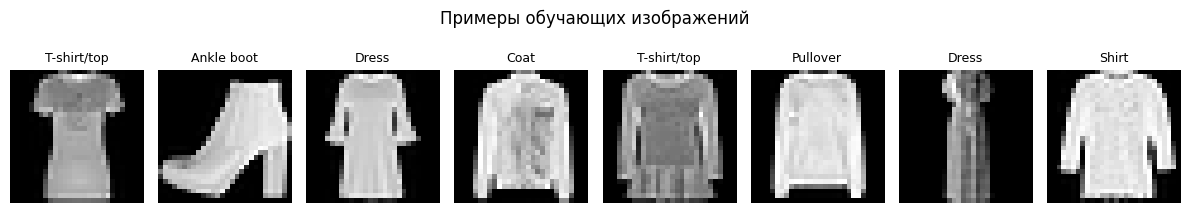

In [20]:
# Визуализация нескольких наблюдений (обратная денормализация для читабельности)
def show_batch(images, labels, n=8):
    imgs = (images[:n].cpu() * 0.5 + 0.5)  # x' -> x
    labs = labels[:n].cpu().numpy().tolist()
    plt.figure(figsize=(12, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(imgs[i, 0], cmap="gray")
        plt.title(CLASS_NAMES[labs[i]], fontsize=9)
        plt.axis("off")
    plt.suptitle("Примеры обучающих изображений", y=1.05)
    plt.tight_layout()
show_batch(xb0, yb0, n=8)

In [21]:
# Определение модели: свёрточная сеть с двумя уровнями свёрток и двумя операциями субдискретизации.
# Выход — логиты (без softmax). CrossEntropyLoss самостоятельно применяет LogSoftmax и NLL.
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1,  32, kernel_size=3, padding=1)   # 1×28×28 -> 32×28×28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)   # 32×28×28 -> 64×28×28
        self.pool  = nn.MaxPool2d(2, 2)                            # 28->14, затем 14->7
        self.drop  = nn.Dropout(0.25)
        self.fc1   = nn.Linear(64*7*7, 128)                        # после двух pool: 64×7×7
        self.fc2   = nn.Linear(128, num_classes)                   # 10 логитов

    def forward(self, x):
        x = F.relu(self.conv1(x))           # 32×28×28
        x = self.pool(F.relu(self.conv2(x)))# 64×14×14
        x = self.pool(x)                    # 64×7×7
        x = self.drop(x)
        x = x.flatten(1)                    # [B, 64*7*7]
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        logits = self.fc2(x)                # [B, 10]
        return logits

model = SmallCNN().to(device)

In [24]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- Функция потерь и оптимизатор ---
# CrossEntropyLoss:
# - стандартная функция потерь для многоклассовой классификации;
# - на вход принимает логиты (сырые выходы модели, до softmax);
# - внутри сама применяет LogSoftmax + NLLLoss.
# AdamW:
# - алгоритм оптимизации (вариант Adam) с weight decay, который реализован корректно
#   и используется для регуляризации (борьба с переобучением).
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

# --- Метрика точности (в батче) ---
# Функция для вычисления accuracy на уровне одного батча:
# 1) argmax(dim=1) выбирает индекс класса с максимальным логитом для каждого объекта;
# 2) сравниваем предсказания с реальными метками;
# 3) приводим булев результат к float (1.0 = верно, 0.0 = неверно) и усредняем.
def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)  # находим предсказанный класс
    return (preds == targets).float().mean().item()  # доля правильных предсказаний

# --- Основной цикл обучения ---
# Здесь реализован процесс обучения нейросети:
# - несколько эпох (проходов по train датасету);
# - в каждой эпохе: обучение на train и оценка на val;
# - после завершения всех эпох: финальная оценка на test.
epochs = 10
for epoch in range(1, epochs + 1):
    # === Тренировочная часть ===
    model.train()  # перевод модели в режим "train" (активирует dropout, batchnorm)
    running_loss, running_acc, n_batches = 0.0, 0.0, 0
    start = time.time()

    for xb, yb in train_loader:
        # xb — батч изображений, yb — соответствующие метки классов
        xb, yb = xb.to(device), yb.to(device)

        # 1) Обнуляем накопленные градиенты
        optimizer.zero_grad(set_to_none=True)

        # 2) Прямой проход: получаем логиты (сырые оценки классов)
        logits = model(xb)  # размерность: [batch_size, num_classes]

        # 3) Вычисляем функцию потерь: сравниваем предсказания с истинными метками
        loss = criterion(logits, yb)

        # 4) Обратное распространение ошибки: считаем градиенты
        loss.backward()

        # 5) Обновляем параметры модели с помощью оптимизатора
        optimizer.step()

        # 6) Сохраняем статистику для усреднения по эпохе
        running_loss += loss.item()
        running_acc  += accuracy_from_logits(logits.detach(), yb)  # detach чтобы не тянуть граф
        n_batches += 1

    # Усреднённые метрики по train за эпоху
    train_loss = running_loss / max(n_batches, 1)
    train_acc  = running_acc  / max(n_batches, 1)

    # === Валидационная часть ===
    # Здесь мы проверяем модель на отложенной выборке (val).
    # В режиме eval отключается dropout, фиксируется поведение batchnorm.
    model.eval()
    val_loss, val_acc, m = 0.0, 0.0, 0
    with torch.no_grad():  # градиенты на валидации не нужны
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            val_loss += loss.item()
            val_acc  += accuracy_from_logits(logits, yb)
            m += 1
    val_loss /= max(m, 1)
    val_acc  /= max(m, 1)

    # --- Вывод результатов за эпоху ---
    dt = time.time() - start
    print(f"[{epoch}/{epochs}] "
          f"train_loss={train_loss:.4f}  train_acc={train_acc:.3f}  "
          f"val_loss={val_loss:.4f}      val_acc={val_acc:.3f}      "
          f"({dt:.1f}s)")

# --- Финальная оценка на тесте ---
# После обучения оцениваем модель на тестовой выборке.
# Здесь метрики вычисляются один раз, чтобы не подгонять под тест.
model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        test_preds.append(logits.argmax(1).cpu())  # сохраняем предсказания классов
        test_targets.append(yb.cpu())              # сохраняем истинные метки

# Объединяем предсказания и метки в массивы numpy для scikit-learn
test_preds   = torch.cat(test_preds).numpy()
test_targets = torch.cat(test_targets).numpy()

# Вывод метрик на тестовом множестве
# Accuracy: общая доля верных предсказаний
# F1 (macro): средний F1 по всем классам (равный вес каждому классу)
# classification_report: precision/recall/F1 по каждому классу
print("\n=== Итоговая оценка на тестовом множестве ===")
print("Accuracy:", accuracy_score(test_targets, test_preds))
print("F1 (macro):", f1_score(test_targets, test_preds, average="macro"))
print("\nОтчёт по классам:\n", classification_report(test_targets, test_preds, target_names=CLASS_NAMES))


[1/10] train_loss=0.2811  train_acc=0.896  val_loss=0.2541      val_acc=0.907      (2.7s)
[2/10] train_loss=0.2478  train_acc=0.908  val_loss=0.2580      val_acc=0.907      (2.7s)
[3/10] train_loss=0.2253  train_acc=0.915  val_loss=0.2584      val_acc=0.908      (2.6s)
[4/10] train_loss=0.2129  train_acc=0.921  val_loss=0.2569      val_acc=0.911      (2.6s)
[5/10] train_loss=0.1934  train_acc=0.929  val_loss=0.2616      val_acc=0.915      (2.7s)
[6/10] train_loss=0.1667  train_acc=0.935  val_loss=0.2744      val_acc=0.917      (2.6s)
[7/10] train_loss=0.1564  train_acc=0.940  val_loss=0.2682      val_acc=0.907      (2.6s)
[8/10] train_loss=0.1410  train_acc=0.947  val_loss=0.2761      val_acc=0.909      (2.7s)
[9/10] train_loss=0.1292  train_acc=0.949  val_loss=0.2630      val_acc=0.915      (2.7s)
[10/10] train_loss=0.1293  train_acc=0.951  val_loss=0.2883      val_acc=0.915      (2.7s)

=== Итоговая оценка на тестовом множестве ===
Accuracy: 0.908
F1 (macro): 0.9048695070032833

Отчё

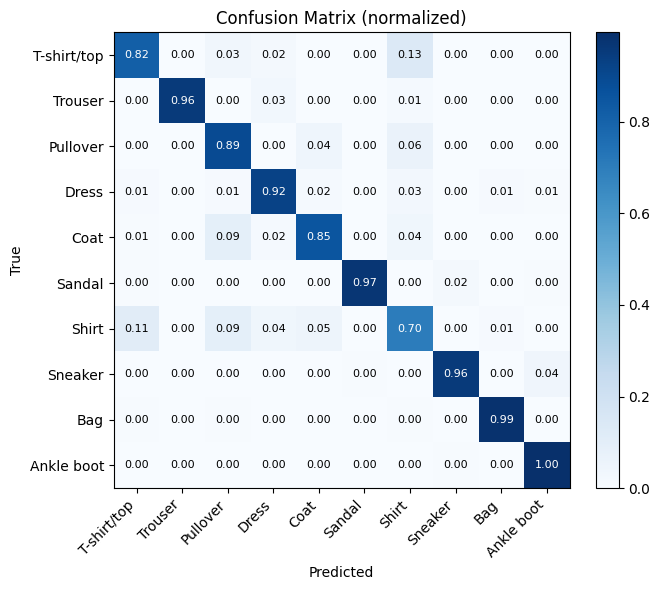

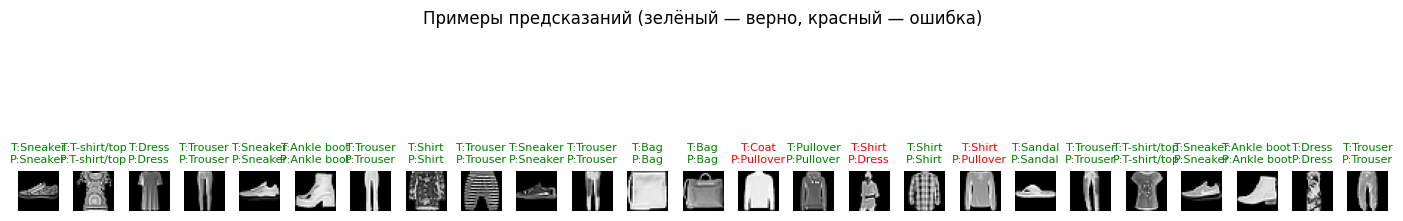

In [25]:
# Матрица ошибок (confusion matrix)
cm = confusion_matrix(test_targets, test_preds, labels=list(range(10)))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7.5,6))
plt.imshow(cm_norm, cmap="Blues")
plt.title("Confusion Matrix (normalized)")
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks(range(10), CLASS_NAMES, rotation=45, ha="right")
plt.yticks(range(10), CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")

th = cm_norm.max() * 0.5
for i, j in itertools.product(range(10), range(10)):
    v = cm_norm[i, j]
    color = "white" if v > th else "black"
    plt.text(j, i, f"{v:.2f}", ha="center", va="center", color=color, fontsize=8)
plt.tight_layout()
plt.show()


# Визуальная проверка нескольких предсказаний на тесте
def show_predictions(ds, model, n=10):
    model.eval()
    idx = torch.randperm(len(ds))[:n]
    ims, trues, preds = [], [], []
    with torch.no_grad():
        for k in idx:
            x, y = ds[k]
            logit = model(x.unsqueeze(0).to(device))
            p = logit.argmax(1).item()
            ims.append(x)
            trues.append(y)
            preds.append(p)
    plt.figure(figsize=(14, 3))
    for i in range(n):
        x = ims[i]*0.5 + 0.5
        plt.subplot(1, n, i+1)
        plt.imshow(x[0], cmap="gray")
        ok = (trues[i] == preds[i])
        title = f"T:{CLASS_NAMES[trues[i]]}\nP:{CLASS_NAMES[preds[i]]}"
        plt.title(title, fontsize=8, color=("green" if ok else "red"))
        plt.axis("off")
    plt.suptitle("Примеры предсказаний (зелёный — верно, красный — ошибка)", y=1.05)
    plt.tight_layout()

show_predictions(test_ds_full, model, n=25)

# Краткие методологические заметки:
# - CrossEntropyLoss требует логиты (не вероятности) и целочисленные индексы классов.
# - Применение Softmax перед CrossEntropyLoss избыточно и численно нежелательно.
# - Метрика точности вычисляется по argmax по размерности классов.
# - Dropout и weight decay выполняют роль регуляризации и снижают риск переобучения.

---
# Ранжирование
---

## MarginRankingLoss

**Определение:**  
Используется, когда нужно обучать модель **сравнивать пары объектов**.  

Для пары $(x_1, x_2)$ и метки $y \in \{-1, +1\}$:
$$
L = \frac{1}{n}\sum_{i=1}^n \max\!\Big(0,\; -y_i \cdot (x_{1,i} - x_{2,i}) + \text{margin}\Big)
$$

- $y_i = +1$ → хотим, чтобы $x_1 > x_2$  
- $y_i = -1$ → хотим, чтобы $x_1 < x_2$  
- `margin` — зазор: даже при правильном порядке можно штрафовать, если разница слишком маленькая.  

---

**Интуиция:**  
- Если пара в правильном порядке → штрафа нет (loss = 0).  
- Если пара нарушает порядок → loss положителен и равен «размеру ошибки».  
- Градиенты подсказывают, как подвинуть $x_1$ и $x_2$, чтобы порядок стал правильным.  

---

**Пример (margin=0):**

Входные данные:
- $x_1 = [0.8, 0.7, -0.2]$  
- $x_2 = [0.1, -0.1, 0.5]$  
- $y = [+1, +1, +1]$  (для всех хотим $x_1 > x_2$)

Разности: $x_1 - x_2 = [0.7, 0.8, -0.7]$

- Пара 1: $y \cdot (x_1 - x_2) = +0.7$ → порядок верный → вклад в loss = 0  
- Пара 2: $y \cdot (x_1 - x_2) = +0.8$ → порядок верный → вклад = 0  
- Пара 3: $y \cdot (x_1 - x_2) = -0.7$ → порядок нарушен → вклад = 0.7  

Итоговый loss:
$$
L = \frac{0 + 0 + 0.7}{3} = 0.2333...
$$

---

**Градиенты:**  
- Для третьей пары $x_1=-0.2$ и $x_2=0.5$:  
  - градиент по $x_1$ отрицательный → оптимизатор будет **увеличивать $x_1$**,  
  - градиент по $x_2$ положительный → оптимизатор будет **уменьшать $x_2$**.  

То есть модель учится «поднять» первый элемент и «опустить» второй, чтобы восстановить порядок.

---

**Когда использовать:**  
- Ранжирование документов/рекомендаций (A > B),  
- Сравнение пар изображений или товаров (лучше/хуже),  
- Любая задача, где важен **порядок**, а не абсолютные значения.  


In [27]:
# MarginRankingLoss — пример с "рекомендациями фильмов"
import torch
import torch.nn as nn

torch.manual_seed(42)

# -----------------------------------------------------------
# Ситуация: у нас есть пользователь, и модель выставляет "скор" фильмам.
# Сравниваем фильм, который пользователь реально посмотрел (pos)
# и случайный фильм, который он НЕ смотрел (neg).
# ХОТИМ: скор(pos) > скор(neg).
# -----------------------------------------------------------

# 3 пары фильмов для одного и того же пользователя
# pos_score — предсказанный "интерес" к реально просмотренному фильму
# neg_score — предсказанный "интерес" к случайному фильму
pos_score = torch.tensor([0.8,  0.7, 0.2], requires_grad=True)   # "правильные" фильмы
neg_score = torch.tensor([0.1, -0.1,  -0.5], requires_grad=True)   # "левые" фильмы

# Для всех пар цель одна: pos > neg → y=+1
# Здесь target = +1 значит: ожидаем, что pos_score больше neg_score.
# (Если бы нужно было pos < neg, то target = -1.)
targets = torch.tensor([+1., +1., +1.], dtype=torch.float)

# -----------------------------------------------------------
# Сценарий A: margin=0 (штрафуем только явные ошибки порядка)
# -----------------------------------------------------------
loss_fn = nn.MarginRankingLoss(margin=0.0, reduction="mean")
loss = loss_fn(pos_score, neg_score, targets)

print("pos_score:", pos_score.detach().numpy())
print("neg_score:", neg_score.detach().numpy())
print("\nЗначение loss:", float(loss))

# Покажем, какие пары "правильные", а какие "провальные"
diff = pos_score.detach() - neg_score.detach()
for i, d in enumerate(diff.tolist()):
    print(f"Пара {i+1}: pos-neg = {d:.2f} → {'OK' if d>0 else 'Ошибка'}")

# -----------------------------------------------------------
# Сценарий B: margin=1.0 (хотим уверенности: разрыв минимум 1)
# -----------------------------------------------------------
loss_fn_margin = nn.MarginRankingLoss(margin=1.0, reduction="mean")
loss_margin = loss_fn_margin(pos_score, neg_score, targets)

print("\nЗначение loss при margin=1.0:", float(loss_margin))

diff = pos_score.detach() - neg_score.detach()
for i, d in enumerate(diff.tolist()):
    if d > 1.0:
        status = "OK (разрыв достаточно большой)"
    elif d > 0:
        status = "Правильно, но слабый разрыв → штраф"
    else:
        status = "Ошибка порядка"
    print(f"Пара: pos-neg = {d:.2f} → {status}")


pos_score: [0.8 0.7 0.2]
neg_score: [ 0.1 -0.1 -0.5]

Значение loss: 0.0
Пара 1: pos-neg = 0.70 → OK
Пара 2: pos-neg = 0.80 → OK
Пара 3: pos-neg = 0.70 → OK

Значение loss при margin=1.0: 0.2666666805744171
Пара: pos-neg = 0.70 → Правильно, но слабый разрыв → штраф
Пара: pos-neg = 0.80 → Правильно, но слабый разрыв → штраф
Пара: pos-neg = 0.70 → Правильно, но слабый разрыв → штраф
